In [7]:
import tensorflow as tf

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [1]:
# Load the dataset
import tensorflow as tf

train, test = tf.keras.datasets.mnist.load_data(path="mnist.npz")
train_x, train_y = train
test_x, test_y = test
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [2]:
# Add random noise to train_x and test_x
train_x_noisey = (train_x + 15* tf.random.normal(shape=train_x.shape)).numpy()
train_x_noisey.shape

(60000, 28, 28)

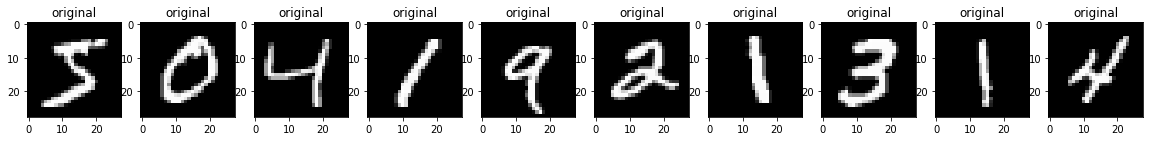

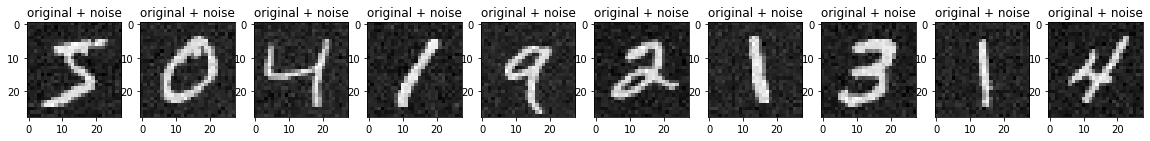

In [3]:
# Create function to plot original and noisey datasets
import matplotlib.pyplot as plt

def plot_original_and_noisey(original=train_x, noisey=train_x_noisey, n=10):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(original[i]))
        plt.gray()
    plt.show()

    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(noisey[i]))
        plt.gray()
    plt.show()

# Plot original train_x and noisey test_x
plot_original_and_noisey()

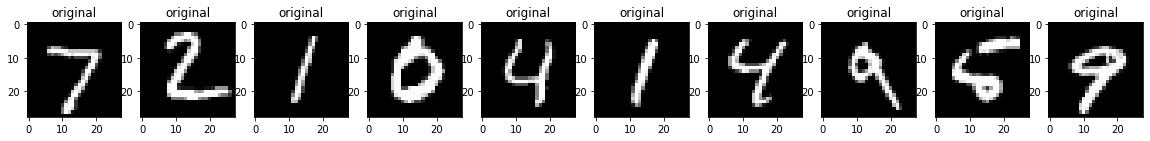

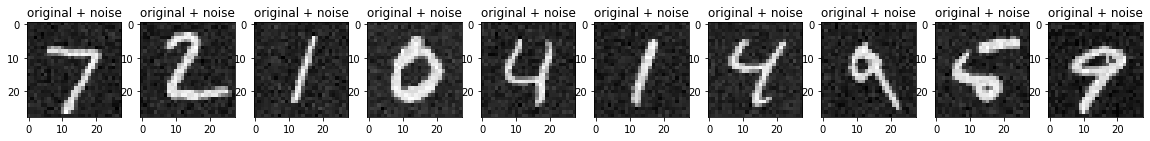

In [4]:
# Plot noisey test_x
test_x_noisey = (test_x + 15* tf.random.normal(shape=test_x.shape)).numpy()
plot_original_and_noisey(original=test_x, noisey=test_x_noisey)

In [5]:
# Split test into validation and test
from sklearn.model_selection import train_test_split

val_x_noisey, test_x_noisey, val_x, test_x = train_test_split(test_x_noisey, test_x, test_size=0.5)
val_x.shape, test_x.shape, val_x_noisey.shape, test_x_noisey.shape

((5000, 28, 28), (5000, 28, 28), (5000, 28, 28), (5000, 28, 28))

In [8]:
# Create checkpoint for model training
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='ImageDenoiser', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [9]:
# Make convolutional autoencoder for image denoising
from tensorflow.keras.layers import InputLayer, Conv2D, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError

class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = Sequential([
          InputLayer(input_shape=(28, 28)),
          Reshape((28, 28, 1)),
          Lambda(lambda x: x / 255),
          Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = Sequential([
          Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())
autoencoder.fit(train_x_noisey, train_x, validation_data=(val_x_noisey, val_x), epochs=10, callbacks=[checkpoint])
autoencoder.summary()

Epoch 1/10
1875/1875 [==============================] - 11s 3ms/step - loss: 921.5518 - val_loss: 232.5495

Epoch 00001: val_loss improved from inf to 232.54950, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 192.4049 - val_loss: 168.1984

Epoch 00002: val_loss improved from 232.54950 to 168.19839, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 152.8058 - val_loss: 140.2484

Epoch 00003: val_loss improved from 168.19839 to 140.24840, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 131.4133 - val_loss: 122.0824

Epoch 00004: val_loss improved from 140.24840 to 122.08236, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\

In [10]:
# Train Longer
autoencoder.fit(train_x_noisey, train_x, validation_data=(val_x_noisey, val_x), epochs=10, callbacks=[checkpoint])

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 86.0187 - val_loss: 84.5739

Epoch 00001: val_loss improved from 86.76879 to 84.57385, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 84.7190 - val_loss: 83.6425

Epoch 00002: val_loss improved from 84.57385 to 83.64246, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 83.5302 - val_loss: 81.9822

Epoch 00003: val_loss improved from 83.64246 to 81.98219, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 82.3580 - val_loss: 81.7803

Epoch 00004: val_loss improved from 81.98219 to 81.78033, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoc

In [11]:
# Describe the Encoder part
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Describe the Decoder part
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Run the noisey test_x through the model
test_x_denoised = autoencoder(test_x_noisey).numpy()
test_x_denoised.shape

(5000, 28, 28, 1)

In [15]:
# Reshape (wouldn't be neccessary if layer was added in the model)
test_x_denoised = test_x_denoised.reshape((5000, 28, 28))
test_x_denoised.shape

(5000, 28, 28)

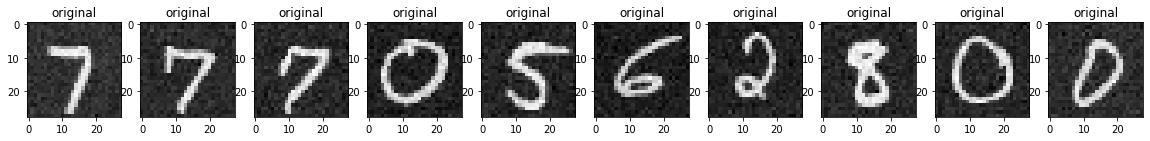

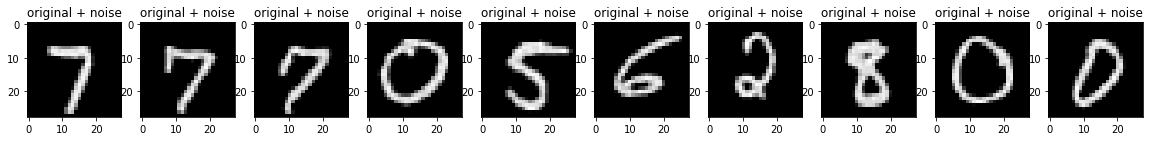

In [16]:
# Plot noisey test_x and cleaned test_x through the model
plot_original_and_noisey(original=test_x_noisey, noisey=test_x_denoised)